# QUANTUM BASTA

During the past years, it has spread the necessity of studying simple quantum systems so as to comprehend how more difficult quantum system behave and evolve. Many approaches has been used, whereas the Agassi's one has been considered very little.

QUANTUM BASTA project is based on the study of the Agassi Model, a nuclear physics approach aimed at the comprehension of the atomic nucleus behaviour. This quantum model is a combination of long range monopole-monopole and short range pairing interactions of N fermions.

The fermions are split into two different levels, each of degeneracy $\Omega$ (which is an even value). Using $\Omega$ we can define $j=\Omega /2$ which will be the parameter that indicates the particles' number considered in the simulation. 
Narrowing it down to the case where $N=2\Omega$, we obtain the relation $N=4*j$ . Another thing that is need to be said is that the two energy levels are identified by a different parity value, σ = -1 and σ = 1, while the magnetic quantum number takes the values m = ±1,...,± j (m = 0 is excluded). Thus, a single-particle state is labelled by (σ = ±,m).

For the work we relied on an article pubblicated on Physical Review B, titled "A digital quantum simulation of the Agassi model" by Pedro Pérez-Fernández (inserire link al paper). The first step consisted in duplicating the paper's results; then we proceeded with improving the code in order to get more reliability and efficiency. 

## Import Libraries

In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


## Choose parameters

In this very first part, all the parameters and variables used are enlisted. $j$,$ \epsilon$,$g$ and $V$ are parameters that define the hamiltonian, and so, the simulation. The others are parameters used within function and loops; each of them is appropriately commented.

In [2]:
# Configure simulation below
# (these are the main parameters you might want to change, more
# specific parameters are defined when needed throughout the notebook)

# Hamiltonian parameters
j   = 1
eps = 1.0
g   = 0.5
V   = 1.0

# Parameters for the time evolution
t_max = 5.0            # Maximum evolution time
time_steps = 300       # Number of time intervals
n_trotter_steps = 10   # Number of Trotter steps
trotter_order = 4      # Trotter order
error_order = 1        # Order of the error scaling

# Automatically determine some variables based on the above
n_qubits = 4 * j
times = np.linspace(0, t_max, time_steps)

# Define the time intervals
initial_state = np.zeros(2**n_qubits)
initial_state[12] = 1.0


## Setup and Helper Functions

The following functions like "`encode_indices`" have the task of encoding the creation and annihilator operators mapping the couple parity-magnetic quantum number $(p,m)$ into a sigle index. The variable $k$ is computated using $p,m,j$ and returns exactly the new index for the operator. As every part of the code, this paragraph is thinked for generalization of j. 

The second function is the inverse process, it helps getting back the couple $(p,m)$ using only the singular operator index. It is important to check the values ​​assumed by the parameters, which is done at the beginning of the functions.

In [3]:
def encode_indices(p, m, j):
    """
    takes two different p, m and j and  encode indexes with the specified rule, it can be used for every value of j 
    """
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

def decode_index(k, j):
    """
    Decode a single index k back into multi-indexes (p, m, j)
    """
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m


for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

The starting point is the hamiltonian which is

$H = \epsilon J^{0} - g \sum_{\sigma, \sigma^\prime = -1,1} A_{\sigma}^{\dagger} A_{\sigma} - \frac{V}{2} \left( (J^+)^2 + (J^-)^2 \right).$ 

For a better comprehension of the terms we refer to the article. Nevertheless, it is crucial to be said that the expression is not usable for digital simulation. It is needed a mapping into another form of the hamiltonian, the one obtained through the Jordan-Wigner trasformation.

The most important part of this paragraph is the function `agassi_hamiltonian` which includes all the commands that defines the different terms of the hamiltonian. Since each term is a linear combination of operators of multiple indexes, we define new operators by using `qml.FermiA()` and `qml.FermiC()` (respectively for annihilators and creators), where we put as arguments the result of the encoding function. In this way, it is possible to obtain a more useful hamiltonian formula.  

Then, we calculate through for loop terms as $J^+$ and $J^-$, while with `A_dag()` and `A()` the second term. Summing up everything we have, we obtain an hamiltonian which can be used as the argument of the Pennylane function `qml.jordan_wigner`. Some things need to be said: the Jordan-Wigner trasformation is a map that, given as input a linear combination of fermionic annihilation and creation operators, return an equivalent expression of spin operators, which are the type of operators usable in quantum systems and quantum simulations. The fermionic operators obey anticommutation rules, whereas spin operators (thus Pauli operators) obey commutation rules. So it is needed a proper transformation. 

Using the formulas $c_i = \frac{1}{2} (\sigma_i^x - i \sigma_i^y) \left( \prod_{j=i+1}^{n} \sigma_j^z \right) $ and $c_i^\dagger = \frac{1}{2} (\sigma_i^x + i \sigma_i^y)\left( \prod_{j=i+1}^{n} \sigma_j^z \right) $, it is possible to change from these different types of operators
We then print the result of the computation.

### Hamiltonian Function Declaration

In [4]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    """
    Compute the hamiltonian expression in creation and annihilation operators, evaluating each terms of the Agassi hamiltonian.
    Every term use the mapping into single index 
    """
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms

    def A_dag(p, j):
        res = 0
        """ 
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res

    def A(p, j):
        res = 0
        """
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)


    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H


### Get Hamiltonian from Specified Parameters

We can get the second quantization hamiltonian by running the following command:

In [5]:
H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)

Second quantization Hamiltonian:
-0.5 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -0.5 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -0.5 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -0.5 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)


The corresponding hamiltonian in terms of pauli sentences are found through:

In [6]:
H_ps = qml.jordan_wigner(H_sec, ps=True)
print("Jordan-Wigner Hamiltonian:")
print(H_ps)

Jordan-Wigner Hamiltonian:
(-0.25+0j) * I
+ (0.375+0j) * Z(2)
+ (0.375+0j) * Z(3)
+ (-0.125+0j) * Z(2) @ Z(3)
+ (-0.1875+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.1875+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.1875+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.1875+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.1875+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.1875+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-0.1875+0j) * X(2) @ Y(3) @ Y(0) @ X(1)
+ (-0.1875+0j) * X(2) @ Y(3) @ X(0) @ Y(1)
+ (-0.125+0j) * Z(0)
+ (-0.125+0j) * Z(1)
+ (-0.125+0j) * Z(0) @ Z(1)


## Determine hamiltonian components for trotterization

#### Helper Functions for Plotting Cliques 
`draw_cliquet_decomposition` is used to draw the clique graph. The necessity of adding this function was due to the fact that by default Pennylane draw graph with only shades of grey. In order to have a more comprehensible diagram, an appropriate number of different colors is generated by `generate_vibrant_colors`. Then, the graph is drawn. 

In [7]:
def draw_cliquet_decomposition(G_base, cliques):

    import matplotlib.pyplot as plt
    import numpy as np

    def generate_vibrant_colors(n_colors):
        """
        Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
        """
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
        colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

        # Keep only highly saturated colors (skip grays)
        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones
        return vibrant_colors[:n_colors]  # Return only the needed number of colors

    # Example: Generate 15 vibrant colors with no grays
    num_cliques = len(cliques)  # Arbitrary dimension
    colors = generate_vibrant_colors(num_cliques)


    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)

    # Draw the original graph in gray (background)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)

    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Helper Function for Manipulating Pennylane Hamiltonian Terms

If Pennylane finds pauli sentences that contain null coefficients related to some pauli words, it erases automatically those terms. This can create some problems if we want to compute calculation between expressions that have different dimensions, because the code doesn't recognise the missing parts. That's why we introduce manually all the terms previously removed from the hamiltonian, exploiting `add_implicit_terms`.

In [8]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    """
    a copy of the hamiltonian given as an input is made, then it is done a check of the pauli words contained within the hamiltonian expression
    and if some specific pauli words have been removed by Pennlyane they're reintroduced pinned to a coefficient equals to 0.0.
    """
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Clique Handling Functions
Trotterization is done splitting hamiltonian into different terms. It is possible to find expressions that give a more truthful calculation of the evolution. To obtain this result, we exploite the properties of graph's theory. The algorithm is thinked to calculate all the cliques defined by the couples pauli's operators-coefficient as nodes and commutation relation between them as links; every clique will then be a hamiltonian term. `get_hamiltonian_graph` constructs the graph considered with nodes and edges (links). `get_clique_partitioning` finds one clique at a time; after having recognized a clique, it deletes all the involved nodes and links and search for other cliques in the remaining part of the graph. `construct_hamiltonian_terms_from_cliques` provides the hamiltonian expression for each clique, translating them into pauli sentences.

In [9]:
def get_hamiltonian_graph(H):
    """
    We compute the hamiltonian graph, evaluating every commutator and adding, if necessary, links between terms
    """

    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)

    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0]    #with the index[0] it takes only the first element aka the operator and it calculates the commutator
            b = H_list[k][0]    #same as above
            if len(a.commutator(b)) == 0:  # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G


def get_clique_partitioning(G, cliques, verbose=False):

    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G)  #automatically finds the clique
        try:
            clique = next(iter_node) #try to find another clique, if there is one advances and finds it
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")

        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques


def construct_hamiltonian_terms_from_cliques(cliques):
    """
    This function reconstructs the hamiltonian terms analyzing for each clique each term contained inside of the clique and
    adding it to the array H_terms, specifying the coefficient associated
    """
    
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

`get_best_clique_partitioning` is thinked for evaluating the most efficient form of the cliques. This part is crucial so as to optimize as much as possible the algorithm and decrease errors in quantum simulation. The idea is the following: whenever two operators commute, it is possible to measure the two observables associated with them in parallel, without quantum interference. So we search for the partitioning that contains the highest number of commutating terms within the cliques.

 One clique at a time is removed from the graph and is computed another clique considering only the remaining nodes. It is then converted into its matrix form exploiting `construct_hamiltonian_terms_from_cliques` and it is calculated the error through the commutators between hamiltonian terms. The error is defined as the sum of the highest eigenvalues of the commutators matrix; that gives information about how much two operators commutes or don't commute. Once every possible partitioning has been explored, the one characterized by the lowest error is the one considered more efficient. 

In [10]:
# get best clique computing by computing trotter error
# At the moment this funciton finds different cliques partition starting from different initial maximal cliques

def get_best_clique_partitioning(G_base, n_qubits, error_order=1, verbose=False):
    best_cliques = None
    best_err = np.inf
    order=list(range(0,n_qubits))

    first_cliques = list(nx.find_cliques(G_base)) #list of all cliques

    def commutator_list(list1, list2):
        """
        create a list containing every commutator between objects belonging to the two input lists
        """

        commutators = []
        for i in range(len(list1)):
            for j in range(len(list2)):
                comm = qml.commutator(list1[i], list2[j], pauli=True)
                commutators.append(comm)
        return commutators

    for first_clique in first_cliques: # first_clique is a single clique contained in the list first_cliques

        G = G_base.copy()
        G.remove_nodes_from(first_clique)   # once it has been removed the i-th clique considered by the loop, 
                                            # the element remaining are manipulated so as to find a new version of the others clique
        cliques = [first_clique]
        cliques = get_clique_partitioning(G, cliques, verbose=verbose)
        commutators = []

        H_terms = construct_hamiltonian_terms_from_cliques(cliques)

        err = 0 
        for i in range(len(H_terms)):
            for j in range(i+1, len(H_terms)):
                first_commutator =qml.commutator(H_terms[i], H_terms[j], pauli=True)
                commutators.append(first_commutator)

        for p in range(1,error_order):  # this is used if we want to consider higher order errors, so it is reiterated the computation with commutators and H_terms
            commutators=commutator_list(H_terms, commutators)

        for comm in commutators:
            if error_order%2 == 0:
                err += np.max(np.abs(np.linalg.eigvalsh(qml.matrix(comm, wire_order=order))))
            else:
                err += np.max(np.abs(np.linalg.eigvalsh(-1j * qml.matrix(comm, wire_order=order))))

        if err < best_err:
            best_err = err
            best_cliques = cliques

    if verbose:
        print("Best error:", best_err)
    
    return best_cliques

### Get Best Clique Decomposition
At this point, the involved functions are called and as  it is drawn the graph, which shows all the cliques using different colors.

In [11]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy() # Save a copy of the original graph for visualization

cliques = get_best_clique_partitioning(G, n_qubits, error_order=error_order, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)
print("number of terms in hamiltonian:", len(H_terms))

number of terms in hamiltonian: 2


`draw_cliquet_decomposition` is used to draw the clique graph. The necessity of adding this function was due to the fact that by default Pennylane draw graph with only shades of grey. In order to have a more comprehensible diagram, an appropriate number of different colors is generated by `generate_vibrant_colors`. Then, the graph is drawn. 

/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_10061/2006917434.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


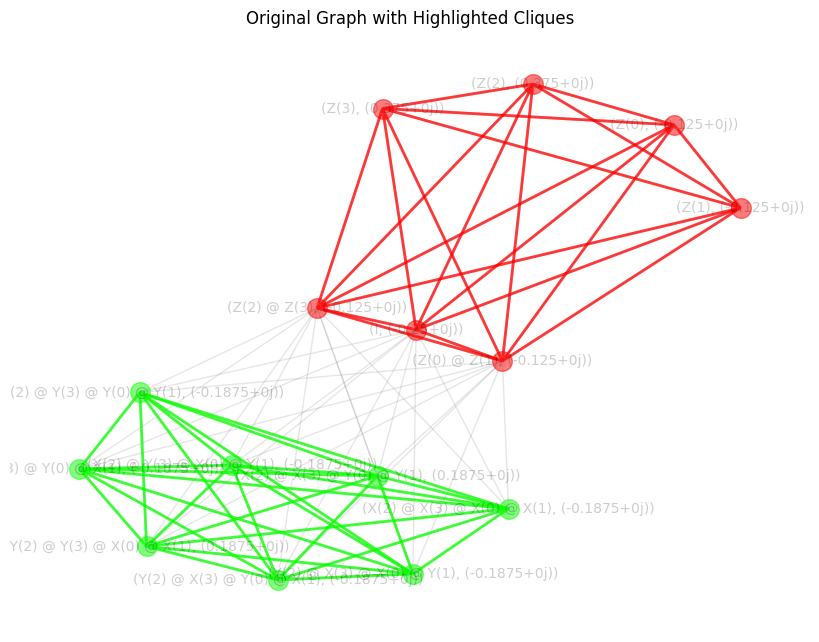

In [12]:
draw_cliquet_decomposition(G_base, cliques)

### Check Commutators
`test_internal_commutativity` and `test_commutativity_among_terms` test commutation when needed. In particular, the first one is in charge of computing the commutation between objects contained in a single hamiltonian term; this is done selecting couples of pauli word and evaluating the commutator. The second one checks the commutativity between hamiltonian terms of a given hamiltonian form; similarly to the first function, differente hamiltonian terms are selected and the commutator is computed. 

In [13]:
# Check that terms within a given clique commute
def test_internal_commutativity(H_term):

    all_commute = True
    split_sentences = {}
    for pauli_word, value in H_term.items():
        if pauli_word not in split_sentences:
            split_sentences[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences.items(), 2):
        comm = qml.commutator(key1,key2, pauli=True)

        # Check if they commute
        if not np.allclose(comm.operation().matrix(), 0):
            all_commute = False

    return all_commute

# Check commutativity amongst all combinations of a given list of terms
def test_commutativity_among_terms(H_terms, verbose=False):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]

            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            print(f"Term {i} and term {j} commute: ", is_commuting)
            if verbose:
                print(f"Term {i}: {ps1}")
                print(f"Term {j}: {ps2}")
                print(f"Commutator: {comm}")

Then, it is checked the commutativity.

In [14]:
print("Testing commutativity within each clique:")
for i in range(len(H_terms)):
    print("Terms within the", str(i) + "-th clique commute: ", test_internal_commutativity(H_terms[i]))

print("\nTesting commutativity amongst different hamiltonian terms:")
test_commutativity_among_terms(H_terms, verbose=False)


Testing commutativity within each clique:
Terms within the 0-th clique commute:  True
Terms within the 1-th clique commute:  True

Testing commutativity amongst different hamiltonian terms:
Term 0 and term 1 commute:  False


## Time Evolution

### Plotting Helper Functions
In order to have a neater code, right after this paragraph, are introduced three functions with the only purpose to plot different results. They will be called later on. 

In [15]:
def plot_results(x, y, title="Results", label="Overlap", xlabel="Time", ylabel="Overlap", ylim=[0, 1.2], xlim=[0, 1]):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

def plot_comparison(x, y1, y2, title="Results", label1="Data 1", label2="Data 2",
                    xlabel="Time", ylabel="Overlap", ylim=[0, 1.2], xlim=[0, 1],
                    alpha=0.7, linestyle1="-", linestyle2="--", figsize=(8, 6), aspect=None):
    plt.figure(figsize=figsize)
    plt.plot(x, y1, label=label1, alpha=alpha, linestyle=linestyle1)
    plt.plot(x, y2, label=label2, alpha=alpha, linestyle=linestyle2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title(title)
    plt.grid()
    plt.legend()
    
    if aspect is not None:
        plt.gca().set_aspect(aspect)
    
    plt.show()

def plot_3D_on_plane(x, y, z , title="Results", xlabel="x_qty", ylabel="y_qty" , zlabel="z_qty", scatter=False):
    plt.figure()
    plt.figure(figsize=(8, 6))
    if scatter:
        plt.scatter(x, y, c=z, cmap='viridis', edgecolors='k')
    else:
        plt.imshow(z, cmap='viridis', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
    plt.colorbar(label=zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x)  # Label x-axis with sigma values
    plt.yticks(y)  # Label y-axis with mu values
    plt.show()

### Helper Functions
When it is required to calculate numerical solutions or results, it is also required to transform the hamiltonian from the pauli sentences representation into its matrix form.
`get_matrix_from_ps`, as it is said in the name, provides the matrix form; it is used for a single pauli sentence. Instead, `get_matrix_from_multiple_ps` is used to obtain the matrix corresponding to a list of pauli sentences; it also implements `add_implicit_terms` function, which purpose has already been explained. 

In [ ]:
# get matrix form of a single pauli sentence
def get_matrix_from_ps(H_ps):
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    mat = qml.matrix(H_ps, wire_order=order)
    return mat

# get matrix form of a list of pauli sentences
# this function makes sure that the size of the matrices is correct
# by automatically adding implicit terms removed by Pennylane
def get_matrix_from_multiple_ps(ps_list, n_qubits):
    ps_list_implicit = []
    for term in ps_list:
        ps_list_implicit.append(add_implicit_terms(term, n_qubits))

    mat_list = []
    for term in ps_list_implicit:
        order = list(range(n_qubits))
        for i in range(0,n_qubits):
            order[i]=i
        mat_list.append(qml.matrix(term, wire_order=order))

    return mat_list

### Exact and Trotterized Evolution Function Declaration
It is now defined the evolution of the initial state in different ways: the first one exploiting the exact evolution, the second one considering an evolution due to the trotterized hamiltonian. The trotterization consists in evalueting the evolution of a state using a fraction of the exponential matrix of the hamiltonian which application is reiterated a number $n$ of times (trotter steps). As every approximation formulas, even the trotterization has infinite order that provides more and more precise result. The Suzuki-Trotter formula at the first order is:

$e^{-i H t} \approx \left( e^{-i H_1 t / N} e^{-i H_2 t / N} \dots e^{-i H_n t / N} \right)^N$

In `exact_evo` function, the initial state, given as input, is evolved using the exact hamiltonian showed at the beginning of the notebook. 
In `paper_evo` function a check on the trotter order is carried out. If the trotter_order is 1, then is computed the evolution of the initial state using the various terms of the hamiltonian in turn. The evolution is carried on for a time $t/n$ and reiterated for n times. Otherwise, it is defined the trotter evolution block for the n-th order, which has to be even (the mathematical reason is that by construction the Suzuki-Trotter formula requires simmetry among positive and negative commutators terms, obtainable only with even orders). `trotter_block` distinguishes between second order and 2k-th order. In the second case, it reproduces the approximation given by 

$S_{2k}(t) = S_{2k-2}(u_k t)^2 S_{2k-2}((1 - 4u_k)t) S_{2k-2}(u_k t)^2$ with $u_k = \frac{1}{4 - 4^{\frac{1}{2k-1}}}$. 

As a final step, it is computed the evolution of the initial state following Suzuki-Trotter formula. Furthermore, it is defined and calculated the evolution using the exact hamiltonian. 

In [17]:
# exact time evolution
def exact_evo(H, initial_state, t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state

# correlation function
def trotter_evo(H_terms_mat, initial_state, t, n, trotter_order=1):

    if trotter_order == 1:
        # U = np.identity(H.shape[0])
        U = np.identity(H_terms_mat[0].shape[0]) # CHECK CHE NON CAMBIA NULLA
        for _ in range(0, n):
            for term in H_terms_mat:
                U = U @ expm(-1j * term * (t/n))

        evolved_state = U @ initial_state
        return evolved_state

    else:
        
        if trotter_order%2 == 1: raise ValueError("Trotter order must be even or 1.")

        # recursive function to compute the trotter block
        def trotter_block(k, t, n):

            # U = np.identity(H.shape[0])
            U = np.identity(H_terms_mat[0].shape[0])
            if k == 1:  # second order (k=trotter_order/2 with trotter_order=2)
                for i in range(len(H_terms_mat)-1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))
                U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

                for i in range(len((H_terms_mat))-2, -1, -1):
                    term = H_terms_mat[i]
                    U = U @ expm(-0.5j * term * (t/n))

                return U

            else:   # 2k-th order of the suzuki-trotter
                u_k = 1/(4-4**(1/(2*k-1)))
                a = trotter_block(k-1, u_k * t, n)
                b = a @ a
                c = trotter_block(k-1, (1 - 4*u_k) * t, n)
                U = b @ c @ b
                return U

        # U = np.identity(H.shape[0])
        U = np.identity(H_terms_mat[0].shape[0])
        block = trotter_block(trotter_order/2, t, n)
        for _ in range(n):
            U = U @ block

        return U @ initial_state

`correlation_function` is the command block whose purpose is to evaluate the correlation function, which is $\sigma_z(1,2) = \braket{\sigma_z^1 \sigma_z^2} - \braket{\sigma_z^1} \braket{\sigma_z^2}$. After defining Z-pauli operators, it uses the evolution of the state obtained with trotterization process, in order to calculate $\sigma_z(1,2)$.

In [18]:
#compute correlation function
def correlation_function(evo, n_qubits=n_qubits, i=0, k=1):
    """calculation of the correlation function for Z-Pauli operators"""

    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw] = 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw] = 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s] = s

    Zi = qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk = qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik = np.vdot(evo, Zi @ Zk @ evo) - np.vdot(evo ,Zi @ evo) * np.vdot(evo, Zk @ evo)
    sigma_ik = np.real(sigma_ik)
    return sigma_ik

During the course of the project, it was useful to consider exclusively the first part of $\sigma_z(1,2)$, expecially while working on the setup defined by $j = 1$, so it was appropriate to create a function which evaluate only that part. 

In [19]:
def correlation_function_first_term_only(evo, n_qubits=n_qubits, i=0, k=1):
    """calculation of the correlation function for Z-Pauli operators"""

    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw] = 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw] = 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s] = s

    Zi = qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk = qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik = np.vdot(evo, Zi @ Zk @ evo)
    sigma_ik = np.real(sigma_ik)
    return sigma_ik

The first three functions are different type of simulation, based on different evolution (exact one is computed in `run_simulation_exact`, trotterized one in `run_simulation_trotter`, trotterized with a variable number of trotter steps in `run_simulation_trotter_variable_trotter_steps`). Correlation and overlap calculation are then automated: `get_correlations_from_states` exploites `correlation_function` to evaluate the desired correlation giving as input the state at which is demanded; `get_overlap_from_states ` returns the overlap between the state evolved with the exact evolution formula and the initial state . In `get_overlap_between_states` it is done the same thing using trotterizad evolution. `get_overlap_between_states` returns the calculation of $\left| \langle \phi(t) | \phi(t)_T \rangle \right|^2$, which is an information of how similar is the state evolved exactly with respect to its trotter evolution.



In [20]:
def run_simulation_exact(H, initial_state, times):
    states = []
    for t in times:
        state = exact_evo(H, initial_state, t)
        states.append(state)
    return states

def run_simulation_trotter(H_terms_mat, initial_state, times, n_trotter_steps, trotter_order):
    states = []
    for t in times:
        state = trotter_evo(H_terms_mat, initial_state, t, n_trotter_steps, trotter_order)
        states.append(state)
    return states

def run_simulation_trotter_variable_trotter_steps(H_terms_mat, initial_state, time, trotter_steps, trotter_order):
    states = []
    for n in trotter_steps:
        state = trotter_evo(H_terms_mat, initial_state, time, n, trotter_order)
        states.append(state)
    return states

def get_correlations_from_states(states, n_qubits, i=0, k=1):
    correlations = []
    for state in states:
        correlation = correlation_function(state, n_qubits, i=i, k=k)
        correlations.append(correlation)
    return correlations

def get_overlap_from_states(states, target_state):
    overlaps = []
    for state in states:
        overlap = np.abs(np.vdot(state, target_state))**2
        overlaps.append(overlap)
    return overlaps

def get_overlap_between_states(states1, states2):
    overlaps = []
    for state1, state2 in zip(states1, states2):
        overlap = np.abs(np.vdot(state1, state2))**2
        overlaps.append(overlap)
    return overlaps

### Compute Evolution
Taking advantage of the above-mentioned functions, the interest quantities are calculated. 

In [21]:
# Compute exact time evolution
H_mat = get_matrix_from_ps(H_ps) 
exact_states = run_simulation_exact(H_mat, initial_state, times)
exact_overlaps = get_overlap_from_states(exact_states, initial_state)
exact_correlations = get_correlations_from_states(exact_states, n_qubits, i=0, k=1)

# Compute trotterized time evolution
H_mat_terms = get_matrix_from_multiple_ps(H_terms, n_qubits) 
trotter_states = run_simulation_trotter(H_mat_terms, initial_state, times, n_trotter_steps, trotter_order)
trotter_overlaps = get_overlap_from_states(trotter_states, initial_state)
trotter_correlations = get_correlations_from_states(trotter_states, n_qubits, i=0, k=1)

# Compare the results at each time step
exact_trotter_ovelaps = get_overlap_between_states(exact_states, trotter_states)

### Plot the results
Exactly under the command block, some graphs are plotted so as to show overlaps and correlation trends. 

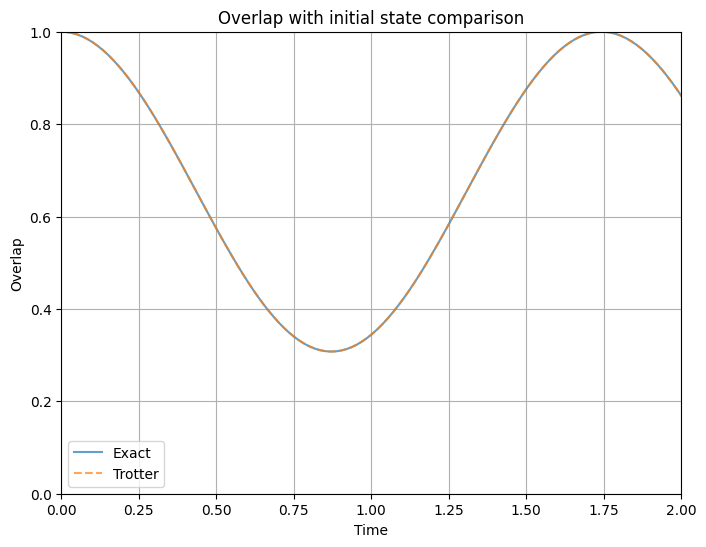

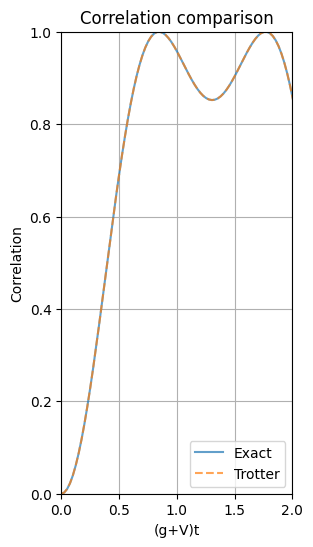

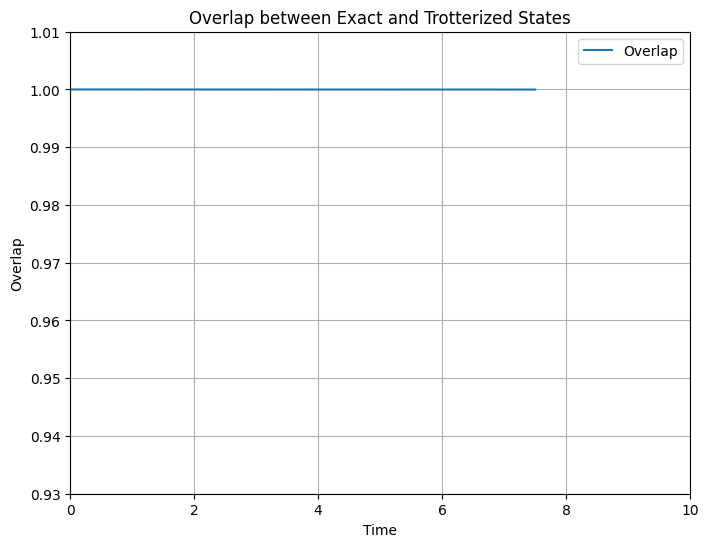

In [22]:
# Uncomment the following lines to plot the results singularly instead

# Plot the results for the exact time evolution
# plot_results(times, exact_overlaps, title="Exact Overlap")
# plot_results(times, exact_correlations, title="Exact Correlation", label="Correlation", ylabel="Correlation")

# Plot the results for the trotterized time evolution
# plot_results(times, trotter_overlaps, title="Trotter Overlap")
# plot_results(times, trotter_correlations, title="Trotter Correlation", label="Correlation", ylabel="Correlation")


# Uncomment the following lines to plot the results together

# Plot the comparison between exact and trotterized time evolution
plot_comparison(times, exact_overlaps, trotter_overlaps,
                title="Overlap with initial state comparison",
                label1="Exact",
                label2="Trotter",
                ylabel="Overlap",
                ylim=[0, 1.0],
                xlim=[0, 2])

# Plot the comparison of correlations obtained from exact and trotterized time evolution
plot_comparison(times*(g+V), exact_correlations, trotter_correlations,
                title="Correlation comparison",
                label1="Exact", 
                label2="Trotter",
                xlabel="(g+V)t",
                ylabel="Correlation",
                ylim=[0,1],
                xlim=[0,2],
                aspect=4.0)

# Plot the scalar product of the states obtained from exact and trotterized time evolution
plot_results(times*(g+V), exact_trotter_ovelaps,
             title="Overlap between Exact and Trotterized States",
             label="Overlap",
             ylabel="Overlap",
             ylim=[0.93,1.01],
             xlim=[0,10])

In a separate plot, it is shown the overlap between exact and trotterized evolution at $t=5s$ evaluated with different values of trotter steps. 

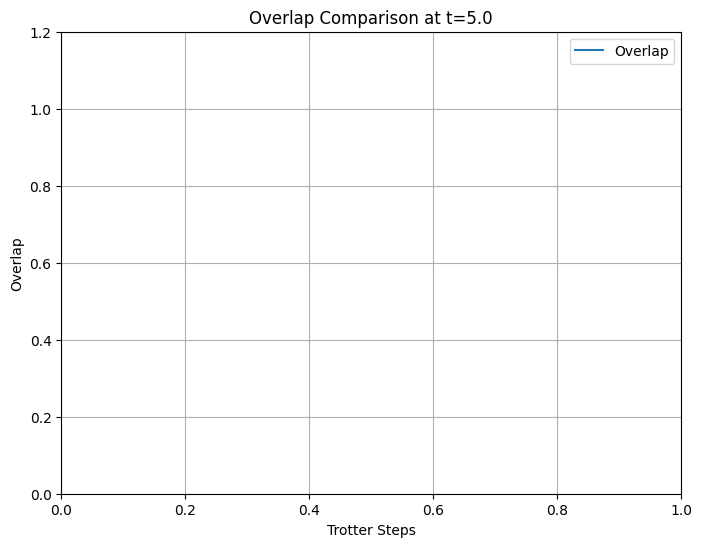

In [23]:
t_comparison = 5.0     # time at which the comparison is made
min_trotter_step = 5   # minimum number of trotter steps
max_trotter_step = 25  # maximum number of trotter steps
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)
trotter_states_variable_trotter_steps = run_simulation_trotter_variable_trotter_steps(H_mat_terms, initial_state, t_comparison, trotter_steps, trotter_order)
exact_state_at_t = exact_evo(H_mat, initial_state, t_max)
overlaps_variable_trotter_steps = get_overlap_from_states(trotter_states_variable_trotter_steps, exact_state_at_t)

plot_results(trotter_steps, overlaps_variable_trotter_steps,
             title="Overlap Comparison at t={}".format(t_comparison),
             label="Overlap",
             xlabel="Trotter Steps",
             ylabel="Overlap")


## Fidelity comparison

In this section we will use the absolute value of the normalized kronecker product between two unitary operators (which is $F(U, V) = \frac{|\text{Tr}(U^\dagger V)|}{N}$) to extract information about the quality of the trotter-suzuki approximation compare to the exact evolution indipendently from the initial state.

### Helper functions
`fidelity` function is defined as the formula above reported. 

In [24]:
def fidelity(U1, U2):
    fidelity = np.abs(np.trace(U1.conj().T @ U2))/U1.shape[0]
    return fidelity 


### Fidelity evaluation functions
`get_fidelity_vs_time` returns the fidelity between exact-evolution operator and trotter-evolution operator at different time values ​​ranging from 0 to a time $t_{max}$. `get_fidelity_vs_trotter_steps` returns the fidelity bewtween exact-evolution operator and trotter-evolution operator at a specific time for different trotter steps number, increasing the quality of the approximation. 

In [25]:
def get_fidelity_vs_time(H_mat_terms, H_mat, times, n_trotter_steps, trotter_order):
    fidelity_product_list_vs_time = []
    initial_state = np.identity(2**n_qubits) #in this way we can obtain the matrix ov the evolution using the previusly defined function
    evo_trotter_list=run_simulation_trotter(H_mat_terms, initial_state, times, n_trotter_steps, trotter_order)
    evo_exact_list=run_simulation_exact(H_mat, initial_state, times)

    for i in range(0, len(times)):
        fidelity_product = fidelity(np.array(evo_trotter_list[i]), np.array(evo_exact_list[i]))
        fidelity_product_list_vs_time.append(fidelity_product)
    
    return fidelity_product_list_vs_time

def get_fidelity_vs_trotter_steps(H_mat_terms, H_mat, time, trotter_steps, trotter_order):
    fidelity_product_list_vs_trotter_steps = []
    initial_state= np.identity(2**n_qubits) #in this way we can obtain the matrix of the evolution using the previusly defined function
    evo_exact=exact_evo(H_mat, initial_state, time)
    evo_trotter_list=run_simulation_trotter_variable_trotter_steps(H_mat_terms, initial_state, time, trotter_steps, trotter_order)

    for i in range(0, len(trotter_steps)):
        fidelity_product = fidelity(np.array(evo_trotter_list[i]), np.array(evo_exact))
        fidelity_product_list_vs_trotter_steps.append(fidelity_product)
    
    return fidelity_product_list_vs_trotter_steps


All the results are plotted. It is important to underline the fact that these information are extrapolated from quantities which are independent from the state considered for the simulation. In fact, it is not included anywhere the initial state or its evolution within the fidelity formula. That means that what is shown is an overall info about the efficiency of the approximation and its use within the simulation.  

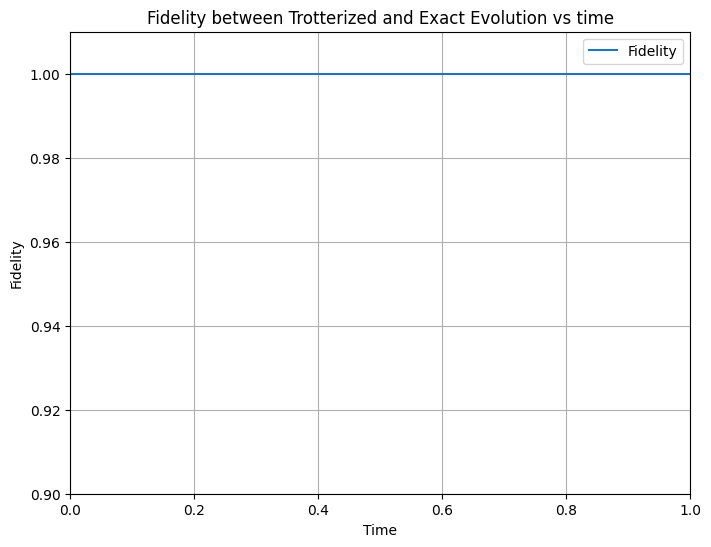

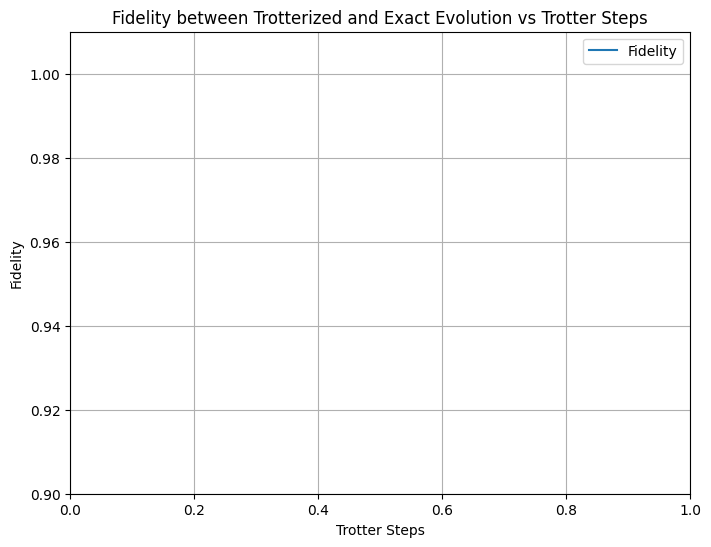

In [26]:

fidelity_product_list_vs_time = get_fidelity_vs_time(H_mat_terms, H_mat, times, n_trotter_steps, trotter_order)

plot_results(times, fidelity_product_list_vs_time,
                title="Fidelity between Trotterized and Exact Evolution vs time",
                label="Fidelity",
                xlabel="Time",
                ylabel="Fidelity",
                ylim=[0.9, 1.01])


fidelity_product_list_vs_trotter_steps = get_fidelity_vs_trotter_steps(H_mat_terms, H_mat, t_comparison, trotter_steps, trotter_order)

plot_results(trotter_steps, fidelity_product_list_vs_trotter_steps,
                title="Fidelity between Trotterized and Exact Evolution vs Trotter Steps",
                label="Fidelity",
                xlabel="Trotter Steps",
                ylabel="Fidelity",
                ylim=[0.9, 1.01])


## Phase transition study
The last part of the notebook is focused on the study of system phase transition.

### Choose parameters for phase transition study
For a neater form of the code, all parameters used are defined at the beginning. In this way, it is possible to change values easily, making the iteration of simulations for different parameters easier. They appear $\Sigma = \frac{\epsilon g}{2j-1}$ and $\Chi = \frac{\epsilon V}{2j-1}$, which will be used below to extrapolate info about model phases. 

In [27]:
sigma_min = 0.0
sigma_max= 2.0
sigma_points_number = 15 # number of points for the sigma values

xi_min = 0.0
xi_max = 2.0
xi_points_number = 15 # number of points for the xi values

t_max = 15.0 # maximum time for the QPT study
time_steps = 15 # number of time steps for the QPT study


sigma_list = np.linspace(sigma_min, sigma_max, sigma_points_number)
xi_list = np.linspace(xi_min, xi_max, xi_points_number)
times = np.linspace(0, t_max, time_steps)


### Helper functions
`get_g_V_from_sigma_xi` returns $g$ and $V$ values, given as input $\Sigma$ and $\Chi$ values. `get_correlations_from_param_list_between_qbit_i_and_k` performs a list of steps: it gets $g$ and $V$ values using `get_g_V_from_sigma_xi`, for each couple $(g,V)$ calculates the hamiltonian in its matrix form, evaluates the state evolved with such hamiltonian, calculates the correlation and its Fourier transform and returns a list with each value of correlation at given $(g,V)$. `cluster_data` applies KMeans unsupervised clustering algorithm to correlations values so as to split them into groups. This is done by creating a KMeans model, by training it and collecting the labels. `project_data_on_low_dimensional_space_PCA`riduces the dimensionality of data using PCA technique, projecting them in a 2D space. 

In [28]:
def get_g_V_from_sigma_xi(sigma, xi, eps, j):
    g = sigma * (2*j-1) / eps
    V = xi * (2*j-1) / eps
    return g, V

def get_correlations_from_param_list_between_qbit_i_and_k(times, sigma_list, xi_list, initial_state=initial_state, i=0, k=1 , fourier_transform=False, verbose=False):
    correlations_list = []
    g_list, V_list = get_g_V_from_sigma_xi(sigma_list, xi_list, eps, j) #extrapolate g and v values
    progress = 0
    n_tot = len(g_list) * len(V_list)
    for g in g_list:
        for V in V_list:
            H = get_matrix_from_ps(qml.jordan_wigner(agassi_hamiltonian(j, eps, g, V), ps=True))
            states = run_simulation_exact(H, initial_state, times)
            correlations = get_correlations_from_states(states, n_qubits, i=i, k=k)
            if fourier_transform:
                correlations_list = fft(correlations_list)

            correlations_list.append(correlations)
            
            progress += 1
            if verbose:
                if progress % 10 == 0:
                    print(f"Progress: {progress}/{n_tot}")
        
    return correlations_list

def cluster_data(data_set, n_clusters=3, seed=2435):
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(data_set)
    labels = kmeans.labels_
    return labels

def project_data_on_low_dimensional_space_PCA(data_set):
    reduced_data = PCA(n_components=2).fit_transform(data_set)
    return reduced_data



### Compute correlation evolution for different $\Sigma$ and $\Chi$
Correlation computation is carried out. 

In [29]:
correlations_list=np.real(np.array(get_correlations_from_param_list_between_qbit_i_and_k(times, sigma_list, xi_list, i=0, k=1, fourier_transform=False, verbose=False)))

### Maximum correlation amplitude with respect to g and V
It is selected the maximum value of the correlation and defined a list with all the maximum values for each parameters couple. Then, two matrices, reppresentin each couple $(\Sigma, \Chi)$ are generated. Once every matrix is converted into a 1D array, each value of correlation are sorted in an increasing order of $\Sigma + \Chi$. The results are then plotted.  

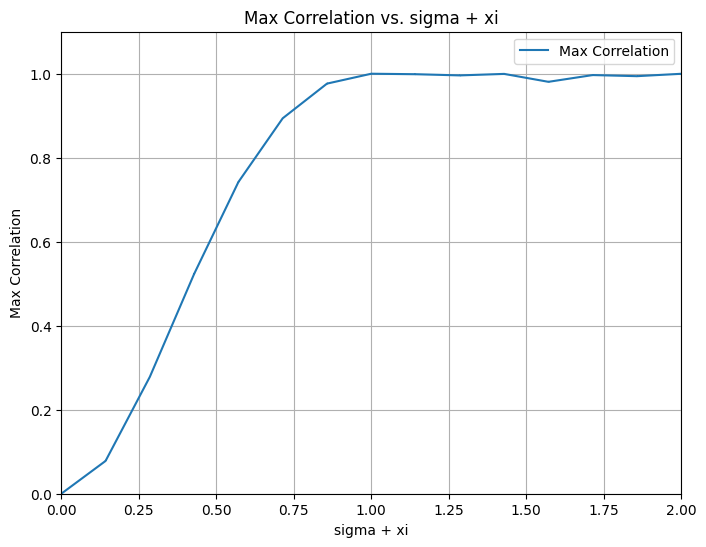

In [30]:
corr_max=np.max(correlations_list, axis=1) 
sigma_mesh, xi_mesh = np.meshgrid(sigma_list, xi_list)

# Compute g + V for each pair
sigma_xi_values = sigma_mesh.flatten() + xi_mesh.flatten()
corr_max_values = corr_max.flatten()

# Sort by g+V values
sorted_indices = np.argsort(sigma_xi_values)
sigma_xi_values_sorted = sigma_xi_values[sorted_indices]
corr_sorted = corr_max_values[sorted_indices]

plot_results(sigma_xi_values_sorted, corr_sorted, 
             title="Max Correlation vs. sigma + xi",
             label="Max Correlation",
             xlabel="sigma + xi",
             ylabel="Max Correlation",
             xlim=[0, 2],      
             ylim=[0.0, 1.1])

This part of the code is thinked for showing in a 3D plot correlation values as a function of $(\Sigma, \Chi)$. Each square, corrisponding to a couple, is colorated with a precise matching among shades and correlation value associated to that couple. 

<Figure size 640x480 with 0 Axes>

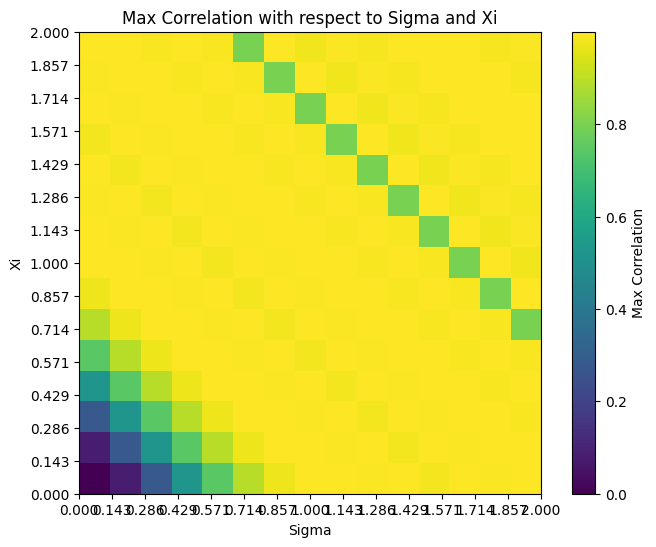

In [31]:
corr_max=corr_max.reshape(sigma_points_number, xi_points_number)

plot_3D_on_plane(sigma_list, xi_list, corr_max, 
                 title="Max Correlation with respect to Sigma and Xi", 
                 xlabel="Sigma", 
                 ylabel="Xi", 
                 zlabel="Max Correlation")



### Plot Max correlations gradeint norm for random states

In [ ]:
# get matrix form of a single pauli sentence
def get_matrix_from_ps(H_ps, n_qubits):
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    mat = qml.matrix(H_ps, wire_order=order)
    return mat

def get_random_state(j=1):
    dim=2**(4*j)
    state=np.empty(dim)
    for i in range(0, dim):
        state[i] = np.random.uniform(0.0, 1.0)
    state=state/np.linalg.norm(state)
    # state=np.zeros(dim)
    # state[12]=1.0
    return state
    
def get_list_of_max_correlations_for_n_number_of_random_states( times, sigma_list, xi_list, eps, j ,i=0, k=1, n=5):
    max_correlation_grad_list=[]
    n_tot=len(sigma_list)*len(xi_list)
    n_qubits=4*j
    for s in range(n):
        print("Sim number: ", s)

        max_correlations_list_xi_sigma=[]
        m = 0
        state=get_random_state(j)
        for sigma in sigma_list:
            max_correlations_sigma=[]
            for xi in xi_list:
                g,V= get_g_V_from_sigma_xi(sigma, xi, eps, j)
                H = get_matrix_from_ps(qml.jordan_wigner(agassi_hamiltonian(j, eps, g, V), ps=True), n_qubits)
                states = run_simulation_exact(H, state, times)
                correlations = get_correlations_from_states(states, n_qubits, i=i, k=k)
                max_correlations_sigma.append(np.max(np.array(correlations)))
                m += 1
                if m%50 == 0:
                    print(f"Progress: {m}/{n_tot}")

            max_correlations_list_xi_sigma.append(max_correlations_sigma)
        
        data = np.array(max_correlations_list_xi_sigma)
        grad1, grad2 = np.gradient(data)
        norm_grad = np.sqrt(grad1**2 + grad2**2)
        max_correlation_grad_list.append(norm_grad)
    return max_correlation_grad_list




In [ ]:
grad_list=np.array(get_list_of_max_correlations_for_n_number_of_random_states(times, sigma_list, xi_list, eps,  i=0, k=1, n=5, j=j))
grad_list_mean=np.mean(grad_list, axis=0)


plot_3D_on_plane(sigma_list, xi_list, grad_list_mean, 
                 title="Mean of gradients norms of Max Correlation with respect to Sigma and Xi", 
                 xlabel="Sigma", 
                 ylabel="Xi", 
                 zlabel="Mean of gradient norm")

Sim number:  0


ValueError: Can't get the matrix for the specified wire order because it does not contain all the Pauli sentence's wires Wires([4, 0, 5, 1, 6, 2, 7, 3])

### Clustering on correlation functions
Clustering results are now plotted. Similarly to the previous plot, indipendent variable are $(\Sigma, \Chi)$. Neverthless, the dependent one is the cluster number. Please refer to the legend in both plot, so as to get an idea of which color is associated each value.  

In [ ]:

labels=cluster_data(data_set=correlations_list, n_clusters=3, seed=2435)
labels_matrix=labels.reshape(len(sigma_list), len(xi_list))

plot_3D_on_plane(sigma_list, xi_list, labels_matrix,
                    title="Clustered Data",
                    xlabel="Sigma",
                    ylabel="Xi",
                    zlabel="Cluster number")

### Visualization of data set on lower dimensional space
PCA dimensionality reduction method is carried out. After finding directions with maximum variance, it projects data into a reduced dimensionality space. It uses eigenvalues and eigenvectors to find principal components, which are linear combo of the original features. In this way, the data reppresentation has a clear meaning and matching with the original form of the plot. 

In [ ]:
correlation_reduced=project_data_on_low_dimensional_space_PCA(correlations_list)

plot_3D_on_plane(correlation_reduced[:,0], correlation_reduced[:,1], labels,
                    title="Reduced Data in 2D",
                    xlabel="PCA component 1",
                    ylabel="PCA component 2",
                    zlabel="Cluster number",
                    scatter=True)
                 

## Extras

the following two codes have been use to explore the space of the evolutions and in order to be able to choose the initial state and the bits for which we want to evaluate the correlations in a sensible way

### check which states evolve

In [ ]:
def get_initial_state(v):
    initial_state = np.zeros(2**n_qubits, dtype=complex)
    initial_state[v] = 1
    return initial_state


def get_overlap_per_qubit_at_time_t(t):
    for v in range(0,2**n_qubits):
        initial_state=get_initial_state(v)
        print(v, np.abs(np.vdot(initial_state, exact_evo(H=H_mat, initial_state=initial_state, t=t))**2))

get_overlap_per_qubit_at_time_t(5.0)

### Check which qubits are correlated

In [ ]:
def get_correlation_per_qubit_at_time_t(t):
    correlations_between_qubits = []
    for i in range(0, n_qubits):
        for k in range(0, i+1):
            evo=exact_evo(H=H_mat, initial_state=initial_state, t=5.0)
            corr=correlation_function(evo=evo, n_qubits=n_qubits ,i=i, k=k)
            corr_only_first_term=correlation_function_first_term_only(evo=evo, n_qubits=n_qubits ,i=i, k=k)
            print(i, k, corr, corr_only_first_term)

get_correlation_per_qubit_at_time_t(5.0)

### Fidelity as in paper

In [ ]:
def get_paper_fidelity(times, H_mat, H_mat_termsm, initial_state):
    overlaps=[]
    for t in times:
        overlap=np.abs(np.vdot(trotter_evo(H_mat_terms, initial_state=initial_state,t=t,n=15,trotter_order=1), exact_evo(H_mat, initial_state,t)))**2
        overlaps.append(overlap)
    return overlaps
overlaps=get_paper_fidelity(times, H_mat, H_mat_terms, initial_state)


In [ ]:
plot_results(times, overlaps)